# UNet 3D Notebook

In [4]:
import os
import torch
import numpy as np
import torch.nn.functional as F
from UNet3D import UNet
from AttUNet import AttUNet
from TransUNet import TransUNet
from monai.networks.nets import SwinUNETR
from monai.networks.layers import Norm

In [2]:
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(pytorch_total_params)

In [5]:
training_dir = os.path.join(os.getcwd(), 'metrics')

def get_paths(mask):
    data_dir = os.path.join(os.getcwd(), 'data/train')
    tmp = []
    for path in Path(data_dir).rglob(mask):
        tmp.append(path.resolve())
    return tmp

In [6]:
training_dir = os.path.join(os.getcwd(), 'metrics')

saved_files = load_metrics("brats_datasplit")
    
train_files, val_files, test_files = saved_lists

In [7]:
import pathlib

images = []
labels = []

for fp in test_files:
    image = pathlib.Path(*fp['image'].parts[5:])
    image = os.path.join(os.getcwd() + '/' + str(image))
    images.append(image)
    label = pathlib.Path(*fp['label'].parts[5:])
    label = os.path.join(os.getcwd() + '/' + str(label))
    labels.append(label)
    
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]

In [7]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), # Load image file or files from provided path based on reader.
        EnsureChannelFirstd(keys=["image", "label"]), #adds a channel dimension if the data doesn't have one ... torch.Size([1, ...]) = torch.Size([1, 1, ...
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Rotate90d(keys=["image", "label"], k=1, spatial_axes=(0,2)), # rotate data so it looks like it should do? ... doesn't feel right when viewing otherwise
        ScaleIntensityRanged(
            keys=["image"], a_min=0.0, a_max=302.0,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        EnsureTyped(keys=["image", "label"]) # converts the data to a pytorch tensor
    ]
)

In [8]:
val_ds = Dataset(data=data_dicts, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [9]:
# model = UNet().to(device)

# model = AttUNet().to(device)

# model = TransUNet().to(device)

model = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=2, feature_size=48).to(device)

<All keys matched successfully>

In [10]:
import random

scans = random.choices(range(1,130), k=5)

In [11]:
scans

[92, 33, 108, 88, 12]

In [12]:
scan_data = []

In [13]:
for i, data in enumerate(val_loader):
    model.eval()
    with torch.no_grad():
        if in scans:
            roi_size = (96,96,96)
            sw_batch_size = 4
            outputs = sliding_window_inference(
                data["image"], roi_size, sw_batch_size, model
            )
            output = torch.argmax(outputs, dim=1)
            scan = {
                'image': data['image'],
                'label': data['label'],
                'output': output
                   }
            scan_data.append(scan)

In [14]:
for i, data in enumerate(scan_data):
    image = data['image'][0][0].numpy()
    label = data['label'][0][0].numpy()
    output = data['output'][0].numpy().astype(np.int32)
    
    image = nib.Nifti1Image(image, affine=np.eye(4))
    label = nib.Nifti1Image(label, affine=np.eye(4))
    output = nib.Nifti1Image(output, affine=np.eye(4))
    
    nib.save(image, f"{i+1}.image.nii.gz")
    nib.save(label, f"{i+1}.label.nii.gz")
    nib.save(output, f"{i+1}.output.nii.gz")

In [15]:
# image = data['image'][0][0].numpy()
# final_img = nib.Nifti1Image(image, affine=np.eye(4))
# nib.save(final_img, 'image.nii.gz')

# label = data['label'][0][0].numpy()
# final_img = nib.Nifti1Image(label, affine=np.eye(4))
# nib.save(final_img, 'label.nii.gz')

# output = output[0].numpy().astype(np.int32)
# final_img = nib.Nifti1Image(output, affine=np.eye(4))
# nib.save(final_img, 'output.nii.gz')

Reorientate ITK-Snap to 'RSA' for Axial

In [17]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import torch

In [137]:
i = 5

image = os.path.join(os.getcwd(), f'outputs/{i}/image.nii.gz')
label = os.path.join(os.getcwd(), f'outputs/{i}/label.nii.gz')
unet = os.path.join(os.getcwd(), f'outputs/{i}/unet.output.nii.gz')
aunet = os.path.join(os.getcwd(), f'outputs/{i}/aunet.output.nii.gz')
unetr = os.path.join(os.getcwd(), f'outputs/{i}/unetr.output.nii.gz')
swin = os.path.join(os.getcwd(), f'outputs/{i}/swin.output.nii.gz')

In [138]:
image = torch.Tensor(nib.load(image).get_fdata())
label = torch.Tensor(nib.load(label).get_fdata())
unet = torch.Tensor(nib.load(unet).get_fdata())
aunet = torch.Tensor(nib.load(aunet).get_fdata())
unetr = torch.Tensor(nib.load(unetr).get_fdata())
swin = torch.Tensor(nib.load(swin).get_fdata())

torch.Size([189, 233, 197])

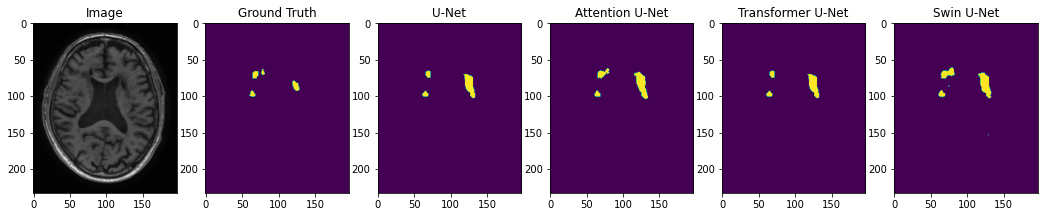

In [43]:
j = 100

# plot the slice [:, :, 80]
plt.figure("check", (18, 6))
plt.subplot(1, 6, 1)
plt.title(f"image")
plt.imshow(image[j, :, :], cmap="gray")
plt.subplot(1, 6, 2)
plt.title(f"Ground Truth")
plt.imshow(label[j, :, :])
plt.subplot(1, 6, 3)
plt.title(f"U-Net")
plt.imshow(unet[j, :, :])
plt.subplot(1, 6, 4)
plt.title(f"Attention U-Net")
plt.imshow(aunet[j, :, :])
plt.subplot(1, 6, 5)
plt.title(f"Transformer U-Net")
plt.imshow(unet[j, :, :])
plt.subplot(1, 6, 6)
plt.title(f"Swin U-Net")
plt.imshow(swin[j, :, :])
# plt.savefig('scan' + str(i) + '.jpg')
plt.show()

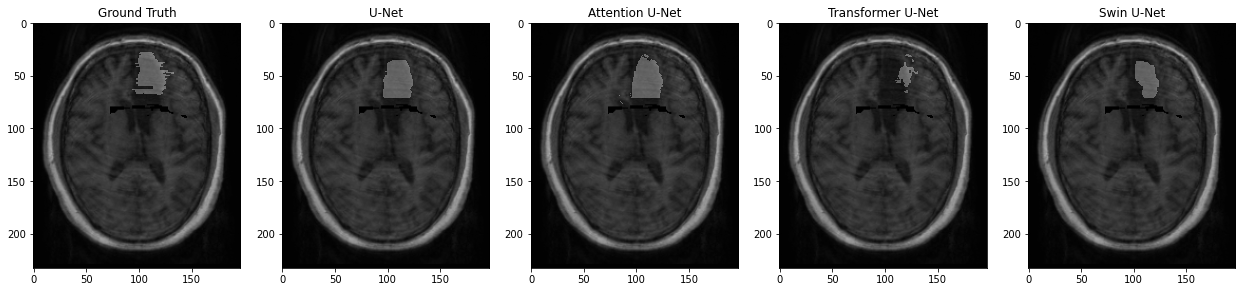

In [161]:
j = 100

# plot the slice [:, :, 80]
plt.figure("check", (26, 6))
plt.subplot(1, 6, 1)
plt.title(f"Ground Truth")
plt.imshow(image[j, :, :], cmap="gray")
plt.imshow(label[j, :, :], interpolation='none', alpha=0.3, cmap="gray")
plt.subplot(1, 6, 2)
plt.title(f"U-Net")
plt.imshow(image[j, :, :], cmap="gray")
plt.imshow(unet[j, :, :], interpolation='none', alpha=0.3, cmap="gray")
plt.subplot(1, 6, 3)
plt.title(f"Attention U-Net")
plt.imshow(image[j, :, :], cmap="gray")
plt.imshow(aunet[j, :, :], interpolation='none', alpha=0.3, cmap="gray")
plt.subplot(1, 6, 4)
plt.title(f"Transformer U-Net")
plt.imshow(image[j, :, :], cmap="gray")
plt.imshow(unetr[j, :, :], interpolation='none', alpha=0.3, cmap="gray")
plt.subplot(1, 6, 5)
plt.title(f"Swin U-Net")
plt.imshow(image[j, :, :], cmap="gray")
plt.imshow(swin[j, :, :], interpolation='none', alpha=0.3, cmap="gray")
plt.savefig('scan1-cerebellum.jpg')
plt.show()